# Kaggle_Future_sales

In [1]:
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing, linear_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# from google.colab import drive
# import os
# drive.mount('/content/gdrive')
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [3]:
# %cd /content/gdrive/My Drive/Kaggle

In [4]:
# train=pd.read_csv('competitive-data-science-predict-future-sales/sales_train.csv')
# test=pd.read_csv('competitive-data-science-predict-future-sales/test.csv')
train=pd.read_csv('/Users/jimmyfu87/JupyterNotebook/Dataset/competitive-data-science-predict-future-sales/sales_train.csv')
test=pd.read_csv('/Users/jimmyfu87/JupyterNotebook/Dataset/competitive-data-science-predict-future-sales/test.csv')

In [5]:
print(train.shape)
print(test.shape)

(2935849, 6)
(214200, 3)


In [6]:
train.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')

In [7]:
# shop=pd.read_csv('competitive-data-science-predict-future-sales/shops.csv')
# items=pd.read_csv('competitive-data-science-predict-future-sales/items.csv')
# cat=pd.read_csv('competitive-data-science-predict-future-sales/item_categories.csv')
shop=pd.read_csv('/Users/jimmyfu87/JupyterNotebook/Dataset/competitive-data-science-predict-future-sales/shops.csv')
items=pd.read_csv('/Users/jimmyfu87/JupyterNotebook/Dataset/competitive-data-science-predict-future-sales/items.csv')
cat=pd.read_csv('/Users/jimmyfu87/JupyterNotebook/Dataset/competitive-data-science-predict-future-sales/item_categories.csv')

# Feature engineering

In [8]:
#移除train中不需要的column，製作item_id對應的item_price表格
drop_elements=['date', 'date_block_num','item_cnt_day']
price_df = train.drop(drop_elements,axis=1)
price_df = price_df.drop_duplicates(['item_id']) 
price_df.head()

shop_id  item_id  item_price
0       59    22154      999.00
1       25     2552      899.00
3       25     2554     1709.05
4       25     2555     1099.00
5       25     2564      349.00

In [9]:
#合併表格，讓test的資料集也有item_price，遺失值約7%
test_p=pd.merge(test,price_df,how='left',on=['item_id'])
test_p.isnull().sum()

ID                0
shop_id_x         0
item_id           0
shop_id_y     15246
item_price    15246
dtype: int64

In [10]:
#整理表格，將item_price的缺漏值填入(mean-std,mean+std)之間的隨機數
drop_e=['shop_id_y']
test_p = test_p.drop(drop_e,axis=1)
test_p.rename(columns={'shop_id_x':'shop_id'})
price_mean=np.mean(test_p['item_price'])
price_std=np.std(test_p['item_price'])
test_p['item_price']=test_p['item_price'].fillna(np.random.randint(price_mean - price_std,price_mean + price_std))
test_p.isnull().sum()

ID            0
shop_id_x     0
item_id       0
item_price    0
dtype: int64

In [11]:
#合併train和test
df=pd.concat([train,test_p],axis=0)

In [12]:
print(shop.shape)
print(items.shape)
print(cat.shape)

(60, 2)
(22170, 3)
(84, 2)


In [13]:
#檢查缺失值
df.isnull().sum()

date               214200
date_block_num     214200
shop_id            214200
item_id                 0
item_price              0
item_cnt_day       214200
ID                2935849
shop_id_x         2935849
dtype: int64

In [14]:
# plt.figure(figsize=(20,5))
# sns.boxplot(x="date_block_num", y="item_cnt_day", data=df,width=200)

In [15]:
all_mean=df.groupby(["date_block_num"]).mean()
all_mean.head()

shop_id       item_id  item_price  item_cnt_day  ID  \
date_block_num                                                          
0.0             29.536416  10234.002827  710.622127      1.136477 NaN   
1.0             28.648339   9907.138004  695.866856      1.179325 NaN   
2.0             33.098939  10061.325142  694.688063      1.212572 NaN   
3.0             33.630981  10321.499166  653.633797      1.138998 NaN   
4.0             33.718752  10357.272725  624.179993      1.165771 NaN   

                shop_id_x  
date_block_num             
0.0                   NaN  
1.0                   NaN  
2.0                   NaN  
3.0                   NaN  
4.0                   NaN

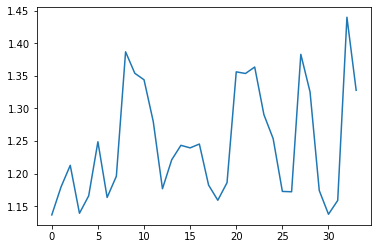

In [16]:
#銷售時間的趨勢
plt.plot(all_mean.index,all_mean['item_cnt_day'])

In [17]:
#a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
#加入年份的feature
df.loc[(df['date_block_num'] <= 11),'Year']='2013'
df.loc[(df['date_block_num'] >= 12) & (df['date_block_num'] <= 23),'Year']='2014'
df.loc[(df['date_block_num'] >= 24) & (df['date_block_num'] <= 33),'Year']='2015'
df.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day  ID  \
0  02.01.2013             0.0     59.0    22154      999.00           1.0 NaN   
1  03.01.2013             0.0     25.0     2552      899.00           1.0 NaN   
2  05.01.2013             0.0     25.0     2552      899.00          -1.0 NaN   
3  06.01.2013             0.0     25.0     2554     1709.05           1.0 NaN   
4  15.01.2013             0.0     25.0     2555     1099.00           1.0 NaN   

   shop_id_x  Year  
0        NaN  2013  
1        NaN  2013  
2        NaN  2013  
3        NaN  2013  
4        NaN  2013

In [18]:
#加入月份的feature
df.loc[(df['date_block_num'] == 0) | (df['date_block_num'] == 12) | (df['date_block_num'] == 24),'Month']=1
df.loc[(df['date_block_num'] == 1) | (df['date_block_num'] == 13) | (df['date_block_num'] == 25),'Month']=2
df.loc[(df['date_block_num'] == 2) | (df['date_block_num'] == 14) | (df['date_block_num'] == 26),'Month']=3
df.loc[(df['date_block_num'] == 3) | (df['date_block_num'] == 15) | (df['date_block_num'] == 27),'Month']=4
df.loc[(df['date_block_num'] == 4) | (df['date_block_num'] == 16) | (df['date_block_num'] == 28),'Month']=5
df.loc[(df['date_block_num'] == 5) | (df['date_block_num'] == 17) | (df['date_block_num'] == 29),'Month']=6
df.loc[(df['date_block_num'] == 6) | (df['date_block_num'] == 18) | (df['date_block_num'] == 30),'Month']=7
df.loc[(df['date_block_num'] == 7) | (df['date_block_num'] == 19) | (df['date_block_num'] == 31),'Month']=8
df.loc[(df['date_block_num'] == 8) | (df['date_block_num'] == 20) | (df['date_block_num'] == 32),'Month']=9
df.loc[(df['date_block_num'] == 9) | (df['date_block_num'] == 21) | (df['date_block_num'] == 33),'Month']=10
df.loc[(df['date_block_num'] == 10) | (df['date_block_num'] == 22),'Month']=11
df.loc[(df['date_block_num'] == 11) | (df['date_block_num'] == 23),'Month']=12
df.tail()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
214195  NaN             NaN      NaN    18454       199.0           NaN   
214196  NaN             NaN      NaN    16188      1223.0           NaN   
214197  NaN             NaN      NaN    15757       199.0           NaN   
214198  NaN             NaN      NaN    19648        99.0           NaN   
214199  NaN             NaN      NaN      969       549.0           NaN   

              ID  shop_id_x Year  Month  
214195  214195.0       45.0  NaN    NaN  
214196  214196.0       45.0  NaN    NaN  
214197  214197.0       45.0  NaN    NaN  
214198  214198.0       45.0  NaN    NaN  
214199  214199.0       45.0  NaN    NaN

In [19]:
#Join所有表格
def mergecol(df):
    df2= pd.merge(df, items, how='left', on=['item_id'])
    df3= pd.merge(df2, shop, how='left', on=['shop_id'])
    df4= pd.merge(df3, cat, how='left', on=['item_category_id'])
    return df4
df4=mergecol(df)

In [20]:
#列出item_name的名字找insight
pd.set_option('display.max_rows', None)
pd.options.display.max_colwidth = 200
allname=pd.DataFrame(items['item_name'].unique())
allname

0
0                                                                                                                   ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D
1                                                                                        !ABBYY FineReader 12 Professional Edition Full [PC, Цифровая версия]
2                                                                                                               ***В ЛУЧАХ СЛАВЫ   (UNV)                    D
3                                                                                                             ***ГОЛУБАЯ ВОЛНА  (Univ)                      D
4                                                                                                                 ***КОРОБКА (СТЕКЛО)                       D
5                                                                                                         ***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ  (UNI)             D
6                                                                                                                    ***УДАР ПО ВОРОТАМ (UNI)               D
7                                                                                                                  ***УДАР ПО ВОРОТАМ-2 (UNI)               D
8                                                                                                                    ***ЧАЙ С МУССОЛИНИ                     D
9                                                                                                               ***ШУГАРЛЭНДСКИЙ ЭКСПРЕСС (UNI)             D
10                                                                                                                  *ЗА ГРАНЬЮ СМЕРТИ                       D
11                                                                                                                  *ЛИНИЯ СМЕРТИ                           D
12                                                                                                                            *МИХЕЙ И ДЖУМАНДЖИ  Сука любовь
13                                                                                                                  *СПАСАЯ ЭМИЛИ                           D
14                                                                                                                  *ЧОКНУТЫЙ ПРОФЕССОР /МАГИЯ/             D
15                                                                                                                     //АДРЕНАЛИН: ОДИН ПРОТИВ ВСЕХ (Регион)
16                                                                                                                                 //МОНГОЛ С.Бодров (Регион)
17                                                                                                                            //НЕ ОСТАВЛЯЮЩИЙ СЛЕДА (Регион)
18                                                                                                                  /БОМБА ДЛЯ НЕВЕСТЫ /2DVD/               D
19                                                                                                                                  /ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72
20                                                                                                                                         /ОДНАЖДЫ В КИТАЕ-2
21                                                                                                                                            /ПОСЛЕДНИЙ ШАНС
22                                                                                                                                       /ПРОКЛЯТЬЕ ЭЛЬ ЧАРРО
23                                                                                                                                          /СЕВЕР И ЮГ /Ч.2/
24                                                                                                                                       /СМЕРТЕЛЬНЫЙ РАСКЛАД
25                                              

In [21]:
#計算含有string的比例
print('PS4 ratio',df4['item_name'].str.contains('PS4').sum()/df4.shape[0])
print('PS3 ratio',df4['item_name'].str.contains('PS3').sum()/df4.shape[0])
print('CD ratio',df4['item_name'].str.contains('CD').sum()/df4.shape[0])
print('PC ratio',df4['item_name'].str.contains('PC').sum()/df4.shape[0])
print('Xbox ratio',df4['item_name'].str.contains('Xbox').sum()/df4.shape[0])
print('DVD ratio',df4['item_name'].str.contains('DVD').sum()/df4.shape[0])

PS4 ratio 0.03445374976706712
PS3 ratio 0.07497788129644968
CD ratio 0.050781749744210326
PC ratio 0.15423379128388162
Xbox ratio 0.06325266686327737
DVD ratio 0.030812219111512235


In [22]:
#製作feature，含有string為1，其餘為0
df4['PS3'] = df4["item_name"].apply(lambda x: 1 if 'PS3' in x else 0)
df4['PS4'] = df4["item_name"].apply(lambda x: 1 if 'PS4' in x else 0)
df4['DVD'] = df4["item_name"].apply(lambda x: 1 if 'DVD' in x else 0)
df4['CD'] = df4["item_name"].apply(lambda x: 1 if 'CD' in x else 0)
df4['PC'] = df4["item_name"].apply(lambda x: 1 if 'PC' in x else 0)
df4['Xbox'] = df4["item_name"].apply(lambda x: 1 if 'Xbox' in x else 0)
df4.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day  ID  \
0  02.01.2013             0.0     59.0    22154      999.00           1.0 NaN   
1  03.01.2013             0.0     25.0     2552      899.00           1.0 NaN   
2  05.01.2013             0.0     25.0     2552      899.00          -1.0 NaN   
3  06.01.2013             0.0     25.0     2554     1709.05           1.0 NaN   
4  15.01.2013             0.0     25.0     2555     1099.00           1.0 NaN   

   shop_id_x  Year  Month                                 item_name  \
0        NaN  2013    1.0                         ЯВЛЕНИЕ 2012 (BD)   
1        NaN  2013    1.0  DEEP PURPLE  The House Of Blue Light  LP   
2        NaN  2013    1.0  DEEP PURPLE  The House Of Blue Light  LP   
3        NaN  2013    1.0  DEEP PURPLE  Who Do You Think We Are  LP   
4        NaN  2013    1.0   DEEP PURPLE 30 Very Best Of 2CD (Фирм.)   

   item_category_id               shop_name  \
0                37  Ярославль ТЦ "Альтаир"   
1                58     Москва ТРК "Атриум"   
2                58     Москва ТРК "Атриум"   
3                58     Москва ТРК "Атриум"   
4                56     Москва ТРК "Атриум"   

                    item_category_name  PS3  PS4  DVD  CD  PC  Xbox  
0                       Кино - Blu-Ray    0    0    0   0   0     0  
1                       Музыка - Винил    0    0    0   0   0     0  
2                       Музыка - Винил    0    0    0   0   0     0  
3                       Музыка - Винил    0    0    0   0   0     0  
4  Музыка - CD фирменного производства    0    0    0   1   0     0

In [23]:
#把test的年份填入2015，月份填入11
df4['Year']=df4['Year'].fillna('2015')
df4['Month']=df4['Month'].fillna(11)

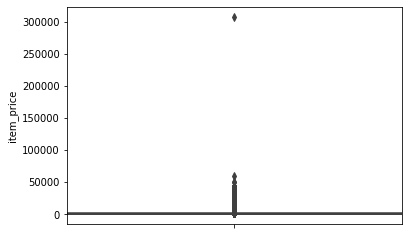

In [24]:
sns.boxplot(y="item_price", data=df4,width=200)

In [25]:
df4.loc[df4['item_price'] < 0].item_price.count()

15247

In [26]:
print(df4.loc[df4.item_price < 0, 'item_price']) 

484683      -1.0
2935850   -331.0
2935853   -331.0
2935894   -331.0
2935913   -331.0
2935914   -331.0
2935919   -331.0
2935923   -331.0
2935924   -331.0
2935926   -331.0
2935958   -331.0
2935988   -331.0
2935993   -331.0
2935994   -331.0
2935995   -331.0
2935997   -331.0
2936017   -331.0
2936026   -331.0
2936037   -331.0
2936038   -331.0
2936048   -331.0
2936049   -331.0
2936050   -331.0
2936054   -331.0
2936055   -331.0
2936070   -331.0
2936071   -331.0
2936079   -331.0
2936092   -331.0
2936093   -331.0
2936180   -331.0
2936191   -331.0
2936204   -331.0
2936215   -331.0
2936219   -331.0
2936243   -331.0
2936258   -331.0
2936259   -331.0
2936265   -331.0
2936266   -331.0
2936267   -331.0
2936268   -331.0
2936275   -331.0
2936316   -331.0
2936329   -331.0
2936330   -331.0
2936340   -331.0
2936346   -331.0
2936349   -331.0
2936362   -331.0
2936364   -331.0
2936379   -331.0
2936385   -331.0
2936390   -331.0
2936399   -331.0
2936424   -331.0
2936426   -331.0
2936427   -331.0
2936461   -331

In [27]:
#price<0不合理，用mean填入
#df4.loc[df4.item_price < 0, 'item_price']=np.mean(df4['item_price'])
df4.iloc[484683,4]=np.mean(df4['item_price'])

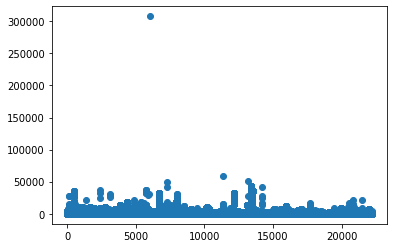

In [28]:
plt.scatter(df4.item_id, df4.item_price)    

In [29]:
print(df4.loc[df4.item_price > 200000, 'item_price']) 

1163158    307980.0
Name: item_price, dtype: float64


In [30]:
#price>200000可能是outlier，用mean填入
#printdf4.loc[df4.item_price > 200000, 'item_price']=np.mean(df4['item_price'])
df4.iloc[1163158,4]=np.mean(df4['item_price'])

In [31]:
df4 = pd.get_dummies(data=df4,columns=['Year'])
df4 = pd.get_dummies(data=df4,columns=['Month'])

In [32]:
df4.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'ID', 'shop_id_x', 'item_name', 'item_category_id',
       'shop_name', 'item_category_name', 'PS3', 'PS4', 'DVD', 'CD', 'PC',
       'Xbox', 'Year_2013', 'Year_2014', 'Year_2015', 'Month_1.0', 'Month_2.0',
       'Month_3.0', 'Month_4.0', 'Month_5.0', 'Month_6.0', 'Month_7.0',
       'Month_8.0', 'Month_9.0', 'Month_10.0', 'Month_11.0', 'Month_12.0'],
      dtype='object')

In [33]:
train_data=df4.iloc[0:2935849,:]
test_data=df4.iloc[2935849:,:]

In [34]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
X =train_data[['PS3', 'PS4', 'DVD', 'CD', 'PC','Xbox', 'Year_2015',  'Month_11.0','item_price']]
y =train_data['item_cnt_day']

(2935849, 8)
[9.99999800e-01 5.65529995e-08 4.56009595e-08 2.45825344e-08
 1.92283556e-08 1.90412586e-08 1.51782594e-08 1.00923888e-08]


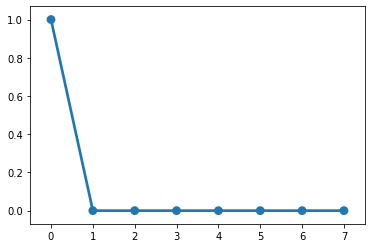

In [35]:
from sklearn import decomposition
pca = decomposition.PCA(n_components='mle')
X_pca=pca.fit_transform(X)
print(X_pca.shape)
print(pca.explained_variance_ratio_)
#PCA結果視覺化
pc=list(range(0,X_pca.shape[1]))
explain_pca=pca.explained_variance_ratio_
dic_pointplot_PCA={"PC":pc,"Explained Variance Ratio":explain_pca}
sns.pointplot(x="PC",y="Explained Variance Ratio",data=dic_pointplot_PCA)

In [36]:
X_train, X_val, y_train, y_val = train_test_split(X_pca, y, test_size=0.3, random_state=33)

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

lr= LinearRegression()
tree=DecisionTreeRegressor(max_depth=2)
rf=RandomForestRegressor(n_estimators=5, random_state=0,max_depth=2)
xgb=XGBRegressor(learning_rate= 0.00015,n_estimators=5,max_depth=2,objective ='reg:squarederror')

lr_model= lr.fit(X_train,y_train)
tree_model=tree.fit(X_train,y_train)
rf_model=rf.fit(X_train,y_train)
xgb_model=xgb.fit(X_train,y_train)

In [38]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
lr_scores=-cross_val_score(lr_model,X,y,cv=5,scoring='neg_root_mean_squared_error')
print('LR Finished！')
tree_scores=-cross_val_score(tree_model,X,y,cv=5,scoring='neg_root_mean_squared_error')
print('Tree Finished！')
rf_scores=-cross_val_score(rf_model,X,y,cv=5,scoring='neg_root_mean_squared_error')
print('RF Finished！')
xgb_scores=-cross_val_score(xgb_model,X,y,cv=5,scoring='neg_root_mean_squared_error')
print('XGB Finished！')

LR Finished！
Tree Finished！
RF Finished！
XGB Finished！


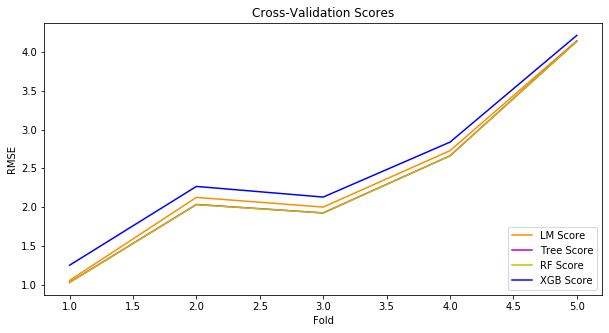

In [39]:
cv=np.arange(1,6)
plt.figure(figsize=(10,5))
plt.plot(cv, lr_scores, color='darkorange',label='LM Score')
plt.plot(cv, tree_scores, color='m',label='Tree Score')
plt.plot(cv, rf_scores, color='y',label='RF Score')
plt.plot(cv, xgb_scores, color='b',label='XGB Score')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('Cross-Validation Scores')
plt.legend(loc="lower right")
plt.show() 

In [40]:
mean_lr=np.mean(lr_scores)
mean_tree=np.mean(tree_scores)
mean_rf=np.mean(rf_scores)
mean_xgb=np.mean(xgb_scores)
print('LR Mean RMSE： ',mean_lr)
print('Tree Mean RMSE： ',mean_tree)
print('RF Mean RMSE： ',mean_rf)
print('XGB Mean RMSE： ',mean_xgb)

LR Mean RMSE：  2.410288644488058
Tree Mean RMSE：  2.357166830776014
RF Mean RMSE：  2.356268870365382
XGB Mean RMSE：  2.539376001313574


In [41]:
X_test =test_data[['PS3', 'PS4', 'DVD', 'CD', 'PC','Xbox','Year_2015', 'Month_11.0','item_price']]
X_test=pca.transform(X_test)
lr_predict = lr_model.predict(X_test)
tree_predict = tree_model.predict(X_test)
rf_predict = rf_model.predict(X_test)
xgb_predict = xgb_model.predict(X_test)

In [44]:
#相同時優先選擇順序： XGB > RandomForest > Linear Regression > Decision Tree
def best_model():
    if(mean_xgb==min(mean_lr,mean_tree,mean_rf,mean_xgb)):
        submit['item_cnt_month'] = xgb_predict
        print('Best model is XGBoost')
    elif(mean_tree==min(mean_lr,mean_tree,mean_rf,mean_xgb)):
        submit['item_cnt_month'] = rf_predict
        print('Best model is RandomForest')
    elif(mean_lr==min(mean_lr,mean_tree,mean_rf,mean_xgb)):
        submit['item_cnt_month'] = lr_predict
        print('Best model is Linear Regression')
    else:
        submit['item_cnt_month'] = tree_predict
        print('Best model is Decision Tree')

In [45]:
submit = pd.read_csv('/Users/jimmyfu87/JupyterNotebook/Dataset/competitive-data-science-predict-future-sales/sample_submission.csv')
best_model()
submit.to_csv('/Users/jimmyfu87/JupyterNotebook/Submit_result/submit_sales.csv', index= False)

Best model is Decision Tree
